label
ham     4825
spam     747
Name: count, dtype: int64


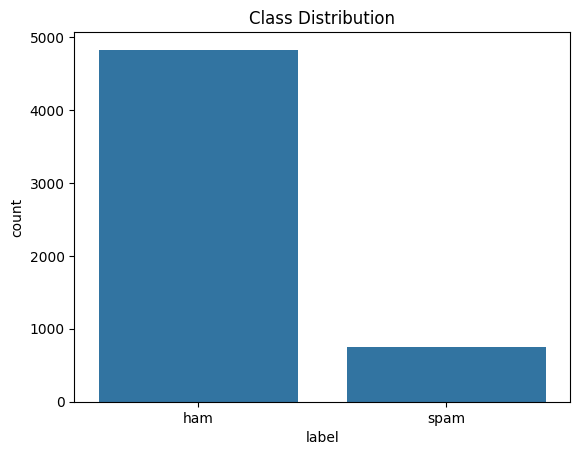

In [5]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# === Load and Clean Data ===
url = "https://raw.githubusercontent.com/gyq1985/nlp/main/spam.csv"
df = pd.read_csv(url, encoding='latin-1')
df = df[['spamORham', 'Message']].rename(columns={'spamORham': 'label', 'Message': 'text'})

# Check class distribution
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.title("Class Distribution")
plt.show()

In [2]:
# === Encode Labels ===
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

X = df['text']
Y = df['label'].values.reshape(-1, 1)

# === Train/Test Split ===
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# === Tokenization ===
max_words = 5000
max_len = 150
tok = Tokenizer(num_words=max_words, oov_token='<OOV>')
tok.fit_on_texts(X_train)

X_train_seq = tok.texts_to_sequences(X_train)
X_test_seq = tok.texts_to_sequences(X_test)

X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)

# === Class Weights ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train.flatten())
class_weights = dict(enumerate(class_weights))

# === Model Definition ===
def build_model():
    inputs = Input(shape=(max_len,), name='inputs')
    x = Embedding(max_words, 64, input_length=max_len)(inputs)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(32)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='sigmoid', name='output')(x)
    model = Model(inputs, x)
    return model

model = build_model()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 150, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 150, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 367,617 (1.40 MB)

 Trainable params: 367,617 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# === Train Model ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_pad, Y_train,
    batch_size=64,
    epochs=10,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 256ms/step - accuracy: 0.7304 - loss: 0.5515 - val_accuracy: 0.9114 - val_loss: 0.2696
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 363ms/step - accuracy: 0.9660 - loss: 0.1643 - val_accuracy: 0.9843 - val_loss: 0.0642
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 246ms/step - accuracy: 0.9862 - loss: 0.0955 - val_accuracy: 0.9765 - val_loss: 0.0924
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.9869 - loss: 0.0623 - val_accuracy: 0.9821 - val_loss: 0.0537
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.9921 - loss: 0.0374 - val_accuracy: 0.9742 - val_loss: 0.0688
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 309ms/step - accuracy: 0.9934 - loss: 0.0220 - val_accuracy: 0.9641 - val_loss: 0.1190
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 258ms/step - accuracy: 0.9967 - loss: 0.0146 - val_accuracy: 0.9821 - val_loss: 0.1089



Test Loss: 0.077  |  Test Accuracy: 0.979
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       965
        spam       0.93      0.92      0.92       150

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
[[954  11]
 [ 12 138]]


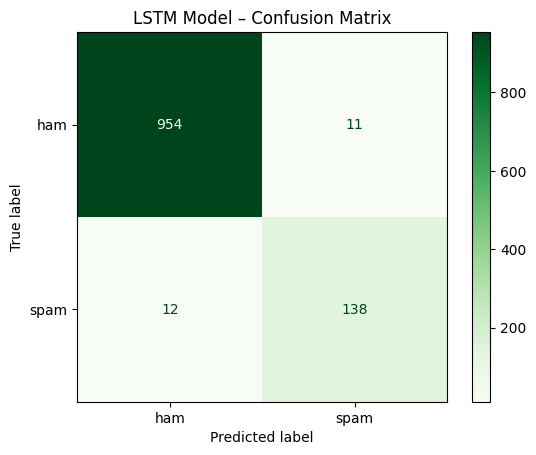

In [6]:
# === Evaluate Model ===
loss, acc = model.evaluate(X_test_pad, Y_test, verbose=0)
print(f"\nTest Loss: {loss:.3f}  |  Test Accuracy: {acc:.3f}")

# === Predict & Classification Report ===
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print metrics
print("\nClassification Report:")
print(classification_report(Y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:")
cm = confusion_matrix(Y_test, y_pred)
print(cm)

# === Plot Confusion Matrix ===
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Greens', values_format='d')  # 你可以换成 'Blues'、'Purples' 等
plt.title("LSTM Model – Confusion Matrix")
plt.show()

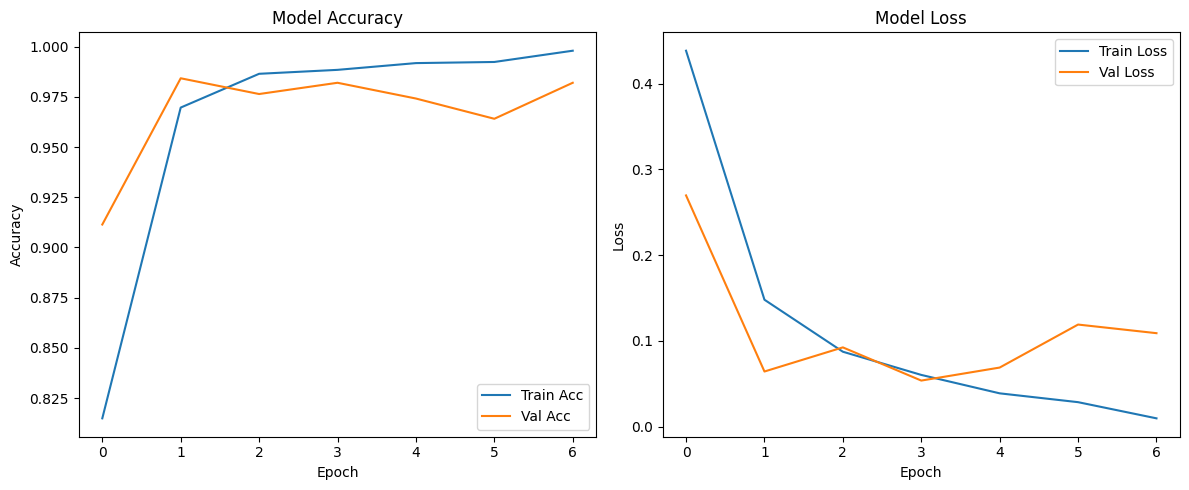

In [7]:
# === Accuracy & Loss Plot ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()